In [1]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("news_articles.csv")

In [3]:
data.head()


,id,title,content
0,25626,"One Weight-Loss Approach Fits All? No, Not Eve...","Dr. Frank Sacks, a professor of nutrition at H..."
1,19551,South Carolina Stuns Baylor to Reach the Round...,South Carolina’s win over Duke was not only ...
2,25221,"U.S. Presidential Race, Apple, Gene Wilder: Yo...",(Want to get this briefing by email? Here’s th...
3,18026,"His Predecessor Gone, Gambia’s New President F...","BANJUL, Gambia — A week after he was inaugu..."
4,21063,‘Harry Potter and the Cursed Child’ Goes From ...,The biggest book of the summer isn’t a blockbu...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       100 non-null    int64 
 1   title    100 non-null    object
 2   content  100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


### Clean Data


In [5]:
# take just the content of the article, lowercase and remove punctuation
articles = data['content'].str.lower().apply(lambda x: re.sub(r"([^\w\s])", "", x))

In [6]:
# stop word removal
en_stopwords = stopwords.words('english')
articles = articles.apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [7]:
# tokenize
articles = articles.apply(lambda x: word_tokenize(x))

In [8]:
# stemming (done for speed as we have a lot of text)
ps = PorterStemmer()
articles = articles.apply(lambda tokens: [ps.stem(token) for token in tokens])

In [9]:
articles

0     [dr, frank, sack, professor, nutrit, harvard, ...
1     [south, carolina, win, duke, surpris, fan, pos...
2     [want, get, brief, email, here, good, even, he...
3     [banjul, gambia, week, inaugur, anoth, countri...
4     [biggest, book, summer, isnt, blockbust, thril...
                            ...                        
95    [want, get, brief, email, here, good, even, he...
96    [tallinn, estonia, guard, brought, ahm, abdul,...
97    [gov, scott, walker, wisconsin, activ, wiscons...
98    [social, media, shook, emot, headlin, shout, n...
99    [moment, joanna, acevedo, first, set, foot, bo...
Name: content, Length: 100, dtype: object

### Vectorization

In [10]:
# create dictionary of all words
dictionary = corpora.Dictionary(articles)
print(dictionary)

Dictionary<8693 unique tokens: ['10', '100', '108', '15', '155']...>


In [11]:
# vecotize using bag of words into a document term matrix
doc_term = [dictionary.doc2bow(text) for text in articles]

### LSA

In [12]:
# specify number of topics
num_topics = 2

In [13]:
# create LSA model
lsamodel = LsiModel(doc_term, num_topics=num_topics, id2word = dictionary) 
print(lsamodel.print_topics(num_topics=num_topics, num_words=5))

[(0, '0.615*"mr" + 0.429*"said" + 0.187*"trump" + 0.130*"state" + 0.119*"would"'), (1, '-0.537*"mr" + -0.319*"trump" + 0.286*"said" + 0.242*"saudi" + 0.142*"weight"')]


### Determine Number of Topics

In [14]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = LsiModel(doc_term, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=articles, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

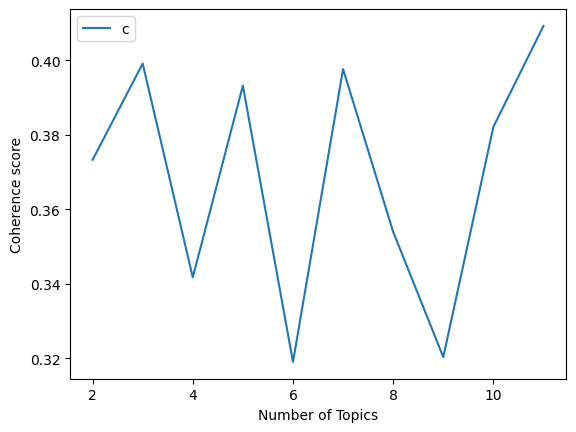

In [15]:
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
final_n_topics = 3
lsamodel_f = LsiModel(doc_term, num_topics=final_n_topics, id2word = dictionary) 
print(lsamodel_f.print_topics(num_topics=final_n_topics, num_words=5))

[(0, '0.615*"mr" + 0.429*"said" + 0.187*"trump" + 0.130*"state" + 0.119*"would"'), (1, '-0.537*"mr" + -0.319*"trump" + 0.286*"said" + 0.242*"saudi" + 0.142*"weight"'), (2, '0.460*"saudi" + 0.264*"taliban" + -0.249*"weight" + 0.194*"afghanistan" + -0.191*"dr"')]
